Sample Data:
  CustomerID TransactionDate  TransactionAmount
0       C103      2024-04-29             473.20
1       C436      2024-02-24             459.37
2       C861      2024-01-27             295.88
3       C271      2024-04-27             236.68
4       C107      2024-08-08             410.97

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerID         5000 non-null   object        
 1   TransactionDate    5000 non-null   datetime64[ns]
 2   TransactionAmount  5000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 117.3+ KB

RFM Dataframe:
  CustomerID  Recency  Frequency  MonetaryValue
0         C1        7          9        2480.44
1        C10       46          6        1559.37
2       C100       85          3         778.78
3      C1000       74    

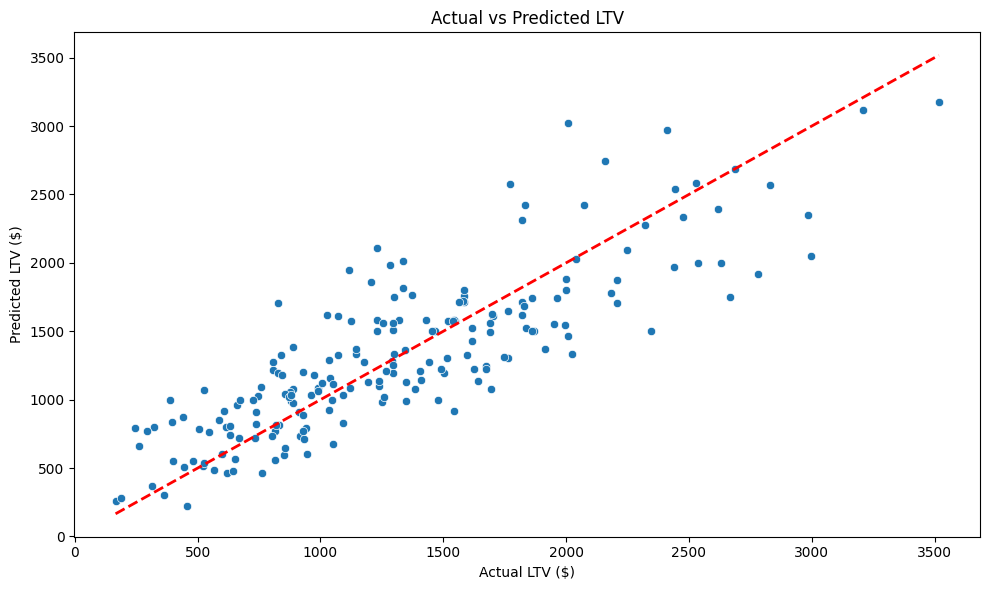


LTV Predictions and Segments:
  CustomerID  Predicted_LTV   LTV_Segment
0         C1    2319.962158    High Value
1        C10    1627.798218    High Value
2       C100     839.161499     Low Value
3      C1000     314.298401     Low Value
4       C101    1112.004272  Medium Value


/tmp/ipython-input-2-3101287833.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


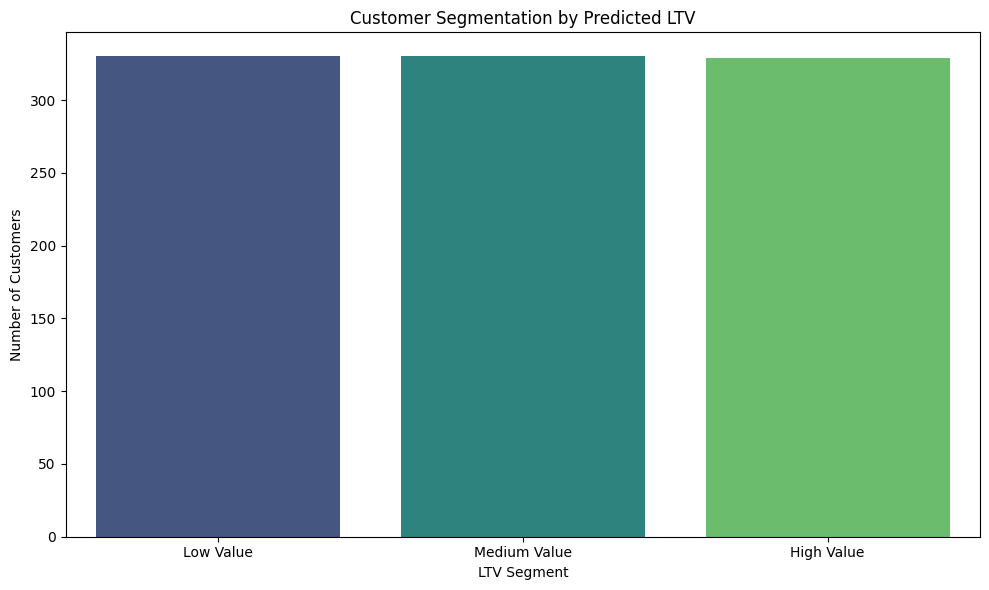


Model saved as ltv_xgb_model.joblib
Predictions saved to ltv_predictions.csv

Final Predictions CSV Head:
  CustomerID  Predicted_LTV   LTV_Segment
0         C1    2319.962158    High Value
1        C10    1627.798218    High Value
2       C100     839.161499     Low Value
3      C1000     314.298401     Low Value
4       C101    1112.004272  Medium Value


In [2]:
# --- Import necessary libraries ---
import pandas as pd
import numpy as np
import datetime as dt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- Data Simulation (Replace this with pd.read_csv in real scenario) ---
np.random.seed(42)
num_customers = 1000
num_transactions = 5000

customer_ids = [f'C{i}' for i in range(1, num_customers + 1)]
data = {
    'CustomerID': np.random.choice(customer_ids, num_transactions),
    'TransactionDate': [dt.date(2024, 1, 1) + dt.timedelta(days=int(d)) for d in np.random.randint(0, 365, num_transactions)],
    'TransactionAmount': np.random.uniform(10, 500, num_transactions).round(2)
}
df = pd.DataFrame(data)

# --- Data Preprocessing ---
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

print("Sample Data:")
print(df.head())

print("\nData Info:")
df.info()

# --- Feature Engineering: RFM Calculation ---
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

rfm_df = df.groupby('CustomerID').agg({
    'TransactionDate': lambda date: (snapshot_date - date.max()).days,
    'TransactionAmount': ['count', 'sum']
}).reset_index()

# Rename columns
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']

print("\nRFM Dataframe:")
print(rfm_df.head())

# --- Model Training ---
X = rfm_df[['Recency', 'Frequency']]
y = rfm_df['MonetaryValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False)

# --- Model Evaluation ---
y_pred = xgb_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- Model Performance ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual LTV ($)")
plt.ylabel("Predicted LTV ($)")
plt.title("Actual vs Predicted LTV")
plt.tight_layout()
plt.show()

# --- Predicting LTV for All Customers ---
rfm_df['Predicted_LTV'] = xgb_reg.predict(rfm_df[['Recency', 'Frequency']])

# --- Customer Segmentation ---
rfm_df['LTV_Segment'] = pd.qcut(rfm_df['Predicted_LTV'], q=3, labels=['Low Value', 'Medium Value', 'High Value'])

print("\nLTV Predictions and Segments:")
print(rfm_df[['CustomerID', 'Predicted_LTV', 'LTV_Segment']].head())

# --- Visualization: Segment Distribution ---
segment_counts = rfm_df['LTV_Segment'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.xlabel("LTV Segment")
plt.ylabel("Number of Customers")
plt.title("Customer Segmentation by Predicted LTV")
plt.tight_layout()
plt.show()

# --- Save Deliverables ---
# Save model
model_filename = 'ltv_xgb_model.joblib'
joblib.dump(xgb_reg, model_filename)
print(f"\nModel saved as {model_filename}")

# Save predictions to CSV
final_predictions_df = rfm_df[['CustomerID', 'Predicted_LTV', 'LTV_Segment']]
csv_filename = 'ltv_predictions.csv'
final_predictions_df.to_csv(csv_filename, index=False)
print(f"Predictions saved to {csv_filename}")

# Show saved content
print("\nFinal Predictions CSV Head:")
print(final_predictions_df.head())